Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.dates as mpdate
import seaborn as sns
from sklearn.metrics import silhouette_score


# Link to the AWS data
# https://drive.google.com/file/d/1zX7jL_mVJ8GNnNYhaQid_z8Cc4YoimVy/view?usp=sharing

filename = "data-cpu_utilization.csv"

data = pd.read_csv(filename)
data.head()

,Time Stamp,Utilization,Label
0,5/14/2014 1:14,85.835,0
1,5/14/2014 1:19,88.167,0
2,5/14/2014 1:24,44.595,0
3,5/14/2014 1:29,56.282,0
4,5/14/2014 1:34,36.534,0


EDA

Text(0, 0.5, 'Count')

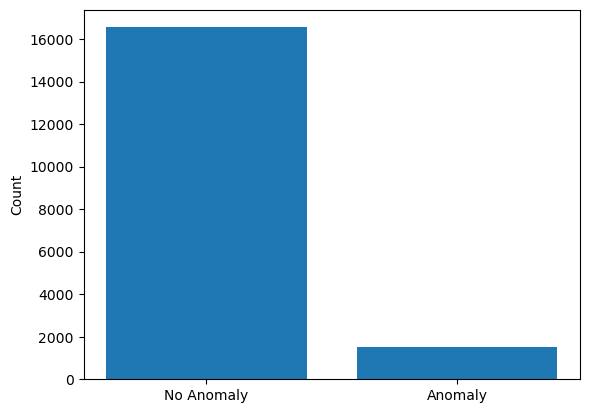

In [3]:
labels = data["Label"].to_frame()
labels["Count"] = 0
labels = labels.groupby(["Label"]).count().reset_index()

plt.bar(labels["Label"], height=labels["Count"])
plt.xticks([0, 1], ["No Anomaly", "Anomaly"])
plt.ylabel("Count")

([<matplotlib.axis.XTick at 0x132372d50>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '80'),
  Text(90, 0, '90')])

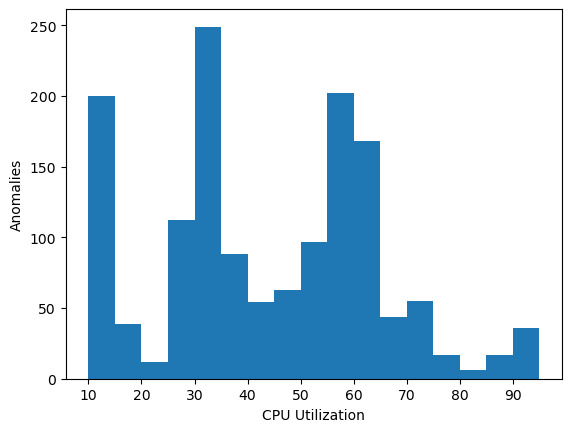

In [4]:
anomaly_utils = data[data["Label"] == 1]
plt.hist(anomaly_utils["Utilization"], bins=np.arange(10, 100, 5))
plt.xlabel("CPU Utilization")
plt.ylabel("Anomalies")
plt.xticks(np.arange(10, 100, 10))

MLP Classifier using CV

In [5]:
train_features, test_features, train_targets, test_targets  = train_test_split(data[["Utilization"]], data["Label"], test_size=0.2, train_size=0.8, shuffle=True, stratify=data["Label"])
hyper_param = {"learning_rate_init": [0.001, 0.005, 0.01, 0.05, 0.1],
               "hidden_layer_sizes": [(100, ), (200, 50), (200, 100, 50), (200, 100, 50, 25), (200, 75, 50, 25, 5)]}
norm_train = StandardScaler().fit_transform(train_features)
gridSearchModel = MLPClassifier(max_iter=200)
nested_cv = GridSearchCV(estimator=gridSearchModel, param_grid=hyper_param, scoring="f1",cv=StratifiedKFold(n_splits=5, shuffle=True))
nested_cv.fit(norm_train, train_targets)

In [ ]:
gridSearchResults = pd.DataFrame(nested_cv.cv_results_)
gridSearchResults

In [ ]:
cleaned_results = gridSearchResults[["param_hidden_layer_sizes", "mean_test_score"]]
best_sizes = cleaned_results.groupby("param_hidden_layer_sizes")["mean_test_score"].max().reset_index().rename(columns={"mean_test_score" : "Mean_F1_Score", "param_hidden_layer_sizes": "Hidden_Layer_Sizes"})
best_sizes.sort_values(by="Mean_F1_Score", ascending=False)

In [ ]:
nested_cv.best_params_

In [ ]:
cross_val = StratifiedKFold(n_splits=10, shuffle=True)
normalizer = StandardScaler()
accuracy = []
loss = [] # using mse
learning_rate = 0.01
hidden_layers = (200, 100, 50, 25)

for tdx, vdx in cross_val.split(train_features, train_targets):
    fold_features, val_features = normalizer.fit_transform(train_features.iloc[tdx]), normalizer.fit_transform(train_features.iloc[vdx])
    fold_targets, val_targets = train_targets.iloc[tdx], train_targets.iloc[vdx]
    cv_mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, learning_rate_init=learning_rate, max_iter=200).fit(fold_features, fold_targets)
    accuracy.append(cv_mlp.score(X=val_features, y=val_targets))
    loss.append(np.mean((cv_mlp.predict(val_features) - val_targets) ** 2))

print(f"Cross Validation Accuracy: {np.mean(accuracy)}")

In [ ]:
train_features, test_features, train_targets, test_targets  = train_test_split(data[["Utilization"]], data["Label"], test_size=0.2, train_size=0.8, shuffle=True, stratify=data["Label"])
mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, learning_rate_init=learning_rate, max_iter=200).fit(normalizer.fit_transform(train_features), train_targets)
mlp.score(normalizer.fit_transform(test_features), test_targets)

In [ ]:
plt.plot(mlp.loss_curve_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.savefig("MLP Loss")

In [ ]:
def classify_prediction(row):
    if row["Predicted"] == 1 and row["Real"] == 1:
        return "TP"
    elif row["Predicted"] == 0 and row["Real"] == 0:
        return "TN"
    elif row["Predicted"] == 1 and row["Real"] == 0:
        return "FP"
    else:
        return "FN"
predictions = mlp.predict(normalizer.fit_transform(test_features))
real_v_predicted = pd.DataFrame({"Predicted": predictions, "Real": test_targets})
real_v_predicted["Classification"] = real_v_predicted.apply(classify_prediction, 1)
TP = real_v_predicted["Classification"][real_v_predicted["Classification"] == "TP"].count()
TN = real_v_predicted["Classification"][real_v_predicted["Classification"] == "TN"].count()
FP = real_v_predicted["Classification"][real_v_predicted["Classification"] == "FP"].count()
FN = real_v_predicted["Classification"][real_v_predicted["Classification"] == "FN"].count()
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

recall = lambda tp, fn: tp / (tp + fn)
precision = lambda tp, fp: tp / (tp + fp)
f1 = lambda r, p: 2 * r * p / (p + r)

print(f"Recall: {recall(TP, FN)}, Precision: {precision(TP, FP)}, F1: {f1(recall(TP, FN), precision(TP, FP))}")

In [ ]:
c_matrix = confusion_matrix(y_true=test_targets, y_pred=predictions, labels=[0, 1])
display = ConfusionMatrixDisplay(c_matrix)
display.plot()
plt.savefig("mlpconfusion")

In [ ]:
def create_cm(predictions, targets, name):
  c_matrix = confusion_matrix(y_true=targets, y_pred=predictions, labels=[0, 1])
  display = ConfusionMatrixDisplay(c_matrix)
  display.plot()
  plt.savefig(name)

Single Layer Perceptron

In [ ]:
cross_val = StratifiedKFold(n_splits=10, shuffle=True)
normalizer = StandardScaler()
train_features, test_features, train_targets, test_targets  = train_test_split(data[["Utilization"]], data["Label"], test_size=0.2, train_size=0.8, shuffle=True, stratify=data["Label"])
accuracy = []
loss = [] # using mse

for tdx, vdx in cross_val.split(train_features, train_targets):
    fold_features, val_features = normalizer.fit_transform(train_features.iloc[tdx]), normalizer.fit_transform(train_features.iloc[vdx])
    fold_targets, val_targets = train_targets.iloc[tdx], train_targets.iloc[vdx]
    cv_slp = Perceptron(max_iter=1000, tol=1e-3).fit(fold_features, fold_targets)
    accuracy.append(cv_slp.score(X=val_features, y=val_targets))
    loss.append(np.mean((cv_slp.predict(val_features) - val_targets) ** 2))

print(f"Cross Validation Accuracy: {np.mean(accuracy)}")

In [ ]:
normalizer = StandardScaler()
train_features, test_features, train_targets, test_targets  = train_test_split(data[["Utilization"]], data["Label"], test_size=0.2, train_size=0.8, shuffle=True, stratify=data["Label"])
slp = Perceptron(max_iter=1000, tol=1e-3).fit(normalizer.fit_transform(train_features), train_targets)
print(slp.score(normalizer.fit_transform(test_features), test_targets))


predictions = slp.predict(normalizer.fit_transform(test_features))
real_v_predicted = pd.DataFrame({"Predicted": predictions, "Real": test_targets})
real_v_predicted["Classification"] = real_v_predicted.apply(classify_prediction, 1)
TP = real_v_predicted["Classification"][real_v_predicted["Classification"] == "TP"].count()
TN = real_v_predicted["Classification"][real_v_predicted["Classification"] == "TN"].count()
FP = real_v_predicted["Classification"][real_v_predicted["Classification"] == "FP"].count()
FN = real_v_predicted["Classification"][real_v_predicted["Classification"] == "FN"].count()
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

recall = lambda tp, fn: tp / (tp + fn)
precision = lambda tp, fp: tp / (tp + fp)
f1 = lambda r, p: 2 * r * p / (p + r)

print(f"Recall: {recall(TP, FN)}, Precision: {precision(TP, FP)}, F1: {f1(recall(TP, FN), precision(TP, FP))}")

In [ ]:
create_cm(slp.predict(normalizer.fit_transform(test_features)), test_targets, "slpconfusion")

NameError: ignored

Logistic Regression

In [ ]:
from sklearn.utils import shuffle

class MyLogisticRegression:
  def __init__(self, learning_rate:float, num_epoch:int, threshold:float=0.5):
    self.learning_rate = learning_rate
    self.num_epoch = num_epoch
    self.threshold = threshold
    self.w = None
    self.bias = None
    self.misclassified_samples = []

  def fit(self, x: pd.DataFrame, y: pd.DataFrame):
    # Initialize weights to 1
    numRows, numCols = x.shape
    self.w = np.zeros((numCols, 1))
    self.bias = 0
    self.misclassified_samples = []

    x = x.to_numpy()
    y = np.array([y.to_numpy()]).T    # Make the array have dimensions 1 x n

    for epoch in range(self.num_epoch):
      # Shuffle dataset
      x, y = shuffle(x, y)

      linear_pred = np.dot(x, self.w) + self.bias
      predictions = self.sigmoid(linear_pred)

      # Update weights
      w_gradient = (1 / numRows) * np.dot(x.T, (predictions - y))
      self.w -= self.learning_rate * w_gradient

      bias_gradient = (1 / numRows) * np.sum(predictions - y)
      self.bias -= self.learning_rate * bias_gradient

      # Record count of the errors during this training iteration
      errors = np.array([[(1 if pred >= self.threshold else 0) for pred in predictions]]).T - y
      self.misclassified_samples.append(np.count_nonzero(errors))

  def sigmoid(self, z: float) -> int:
    return 1 / (1 + np.exp(-z))

  def predict(self, x: pd.DataFrame):
    linear_pred = np.dot(x, self.w) + self.bias
    y_predictions = self.sigmoid(linear_pred)
    class_predictions = [(1 if y >= self.threshold else 0) for y in y_predictions]
    return class_predictions


def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [ ]:
cross_val = StratifiedKFold(n_splits=10, shuffle=True)
normalizer = StandardScaler()
train_features, test_features, train_targets, test_targets = \
    train_test_split(data[["Utilization"]],
                     data["Label"],
                     test_size=0.2,
                     train_size=0.8,
                     shuffle=True,
                     stratify=data["Label"])
cv_accuracy = []
mse = []

for tdx, vdx in cross_val.split(train_features, train_targets):
    fold_features = normalizer.fit_transform(train_features.iloc[tdx])
    val_features = normalizer.fit_transform(train_features.iloc[vdx])
    fold_targets = train_targets.iloc[tdx]
    val_targets = train_targets.iloc[vdx]

    cv_logReg = LogisticRegression(max_iter=1000, tol=1e-3).fit(fold_features, fold_targets)
    cv_accuracy.append(cv_logReg.score(X=val_features, y=val_targets))
    mse.append(np.mean((cv_logReg.predict(val_features) - val_targets) ** 2))

print(f"Cross Validation Accuracy: {np.mean(cv_accuracy)}")

Cross Validation Accuracy: 0.9169667590027701


In [ ]:
normalizer = StandardScaler()
train_features, test_features, train_targets, test_targets = \
    train_test_split(data[["Utilization"]],
                     data["Label"],
                     test_size=0.2,
                     train_size=0.8,
                     shuffle=True,
                     stratify=data["Label"])

# logReg = LogisticRegression(tol=1e-3)
# logReg.fit(train_features, train_targets)
# print("Weights of", logReg.coef_)
# print("Bias of", logReg.intercept_[0])
# logReg.score(test_features, test_targets)

logReg = MyLogisticRegression(learning_rate=0.01, num_epoch=1000)
logReg.fit(train_features, train_targets)
predictions = logReg.predict(test_features)
print("My logistic regression accuracy:", accuracy(test_targets, predictions))
plt.plot(range(1, len(logReg.misclassified_samples) + 1),
         logReg.misclassified_samples, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Errors')
plt.title('Sum of Errors vs. Epoch')
plt.show()

In [ ]:
create_cm(predictions, test_targets, "lrconfusion")
plt.title("Logistic Regression Confusion Matrix")

NameError: ignored

K-Means Clustering

In [ ]:
#RUN ONCE
# converts timestamp into unix time
def to_float(time):
     return time.timestamp()

data["Time Stamp"] = data["Time Stamp"].apply(pd.Timestamp, 0).apply(mpdate.date2num, 0)


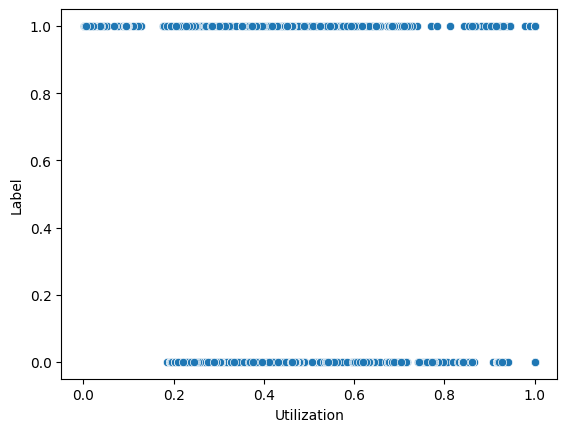

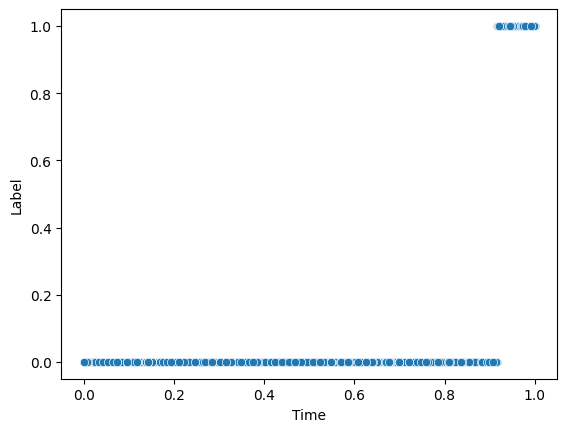

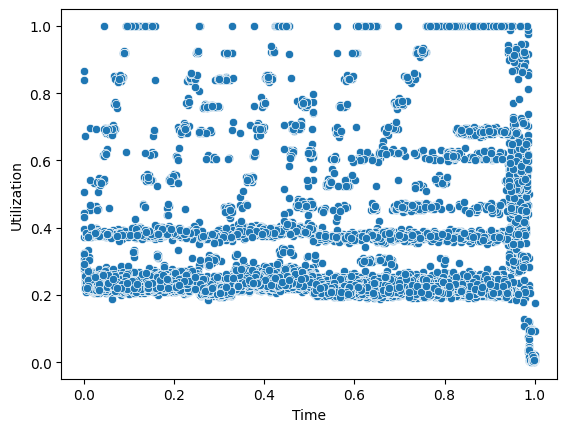

In [ ]:


x = data["Time Stamp"]
y = data.Label
z = data.Utilization

x_normalized = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
y_normalized = MinMaxScaler().fit_transform(np.array(y).reshape(-1, 1))
z_normalized = MinMaxScaler().fit_transform(np.array(z).reshape(-1, 1))

#time label
x_train, x_test, y_train, y_test = train_test_split(
    x_normalized, y_normalized, test_size=0.2, random_state=1234
)

#time util
x2_train, x2_test, y2_train, y2_test = train_test_split(
    x_normalized, z_normalized, test_size=0.2, random_state=1234
)


#util label
x3_train, x3_test, y3_train, y3_test = train_test_split(
    z_normalized, y_normalized, test_size=0.2, random_state=1234
)
# splitting into normalized test/train



# dataframes of X and Y respectively
timeLabel = pd.DataFrame({'Time':x_train.flatten(),'Label':y_train.flatten()})
timeUtil = pd.DataFrame({'Time':x2_train.flatten(),'Utilization':y2_train.flatten()})
UtilLabel = pd.DataFrame({'Utilization':x3_train.flatten(),'Label':y3_train.flatten()})


#graphics for slides

#utilization and label visualized
fig, ax = plt.subplots()
sns.scatterplot(data = UtilLabel ,x="Utilization",y="Label")
plt.show()

#time and label visualized
fig, ax = plt.subplots()
sns.scatterplot(data = timeLabel ,x="Time",y="Label")
plt.show()

#time and utilization visualized
fig, ax = plt.subplots()
sns.scatterplot(data = timeUtil ,x="Time",y="Utilization")
plt.show()





[1205.8139937534602, 302.9506552166994, 132.81472517199956, 75.28125980064947, 48.154666639807, 33.49698735106334, 24.627269094275576, 18.929696573547133, 15.467109105760873, 12.066963178706498]


<Axes: >

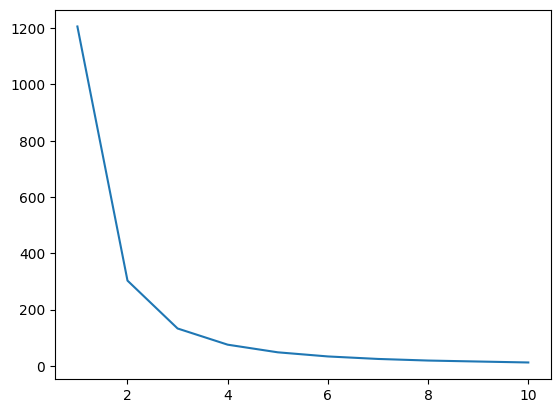

In [ ]:
elbow = []
K = range(1,11)
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, random_state = 0, n_init='auto')
  kmeans.fit(x2_train)
  elbow.append(kmeans.inertia_)

print(elbow)
sns.lineplot(x = K, y = elbow)

<Axes: xlabel='Utilization', ylabel='Label'>

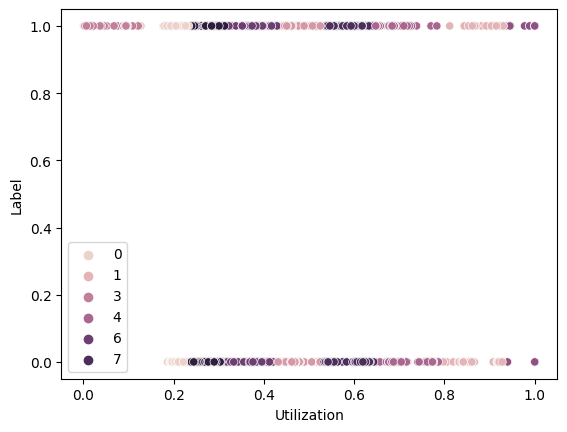

In [ ]:
#graphic for slides
#util and label, clusters visualized
kmeans = KMeans(n_clusters = 9, random_state = 0, n_init='auto')
kmeans.fit(x3_train)
sns.scatterplot(data = UtilLabel, x = 'Utilization', y = 'Label', hue = kmeans.labels_)

<Axes: xlabel='Time', ylabel='Label'>

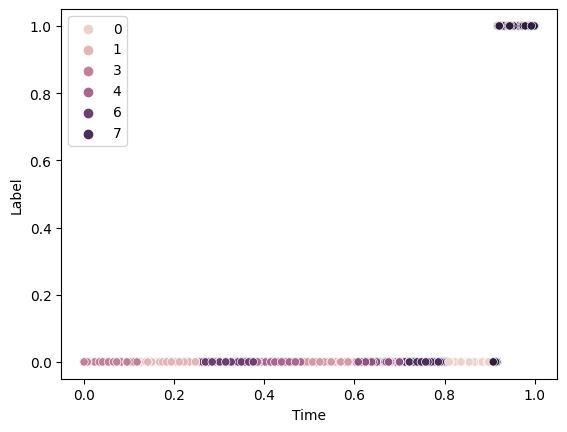

In [ ]:

#graphic for slides
#time and label, clusters visualized
kmeans = KMeans(n_clusters = 9, random_state = 0, n_init='auto')
kmeans.fit(x2_train)
sns.scatterplot(data = timeLabel, x = 'Time', y = 'Label', hue = kmeans.labels_)


fine: [3652, 4747, 4862]
anomaly: [1179, 0, 0]
Anomaly % for each cluster: [0.24404885116953012, 0.0, 0.0]
[320, 2372, 918, 0]


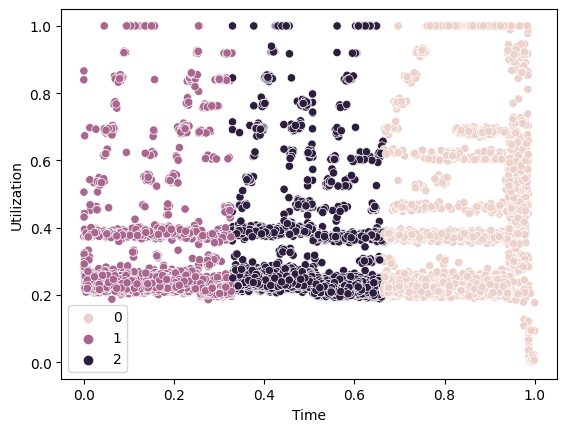

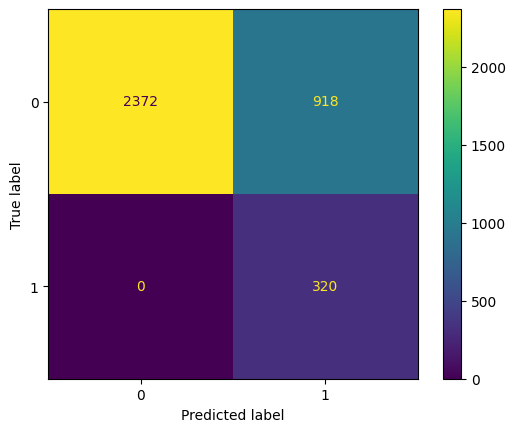

In [ ]:
#important one that looks to be good numerically until you find out its really not

# time X utilization, then assign values?/anoms?
x = data["Time Stamp"]
y = data.Utilization
z = data.Label

x_normalized = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
y_normalized = MinMaxScaler().fit_transform(np.array(y).reshape(-1, 1))
z_normalized = MinMaxScaler().fit_transform(np.array(z).reshape(-1, 1))

x2_train, x2_test, y2_train, y2_test, label_train, label_test = train_test_split(
    x_normalized, y_normalized, z_normalized, test_size=0.2, random_state=1234
)



timeUtil = pd.DataFrame({'Time':x2_train.flatten(),'Utilization':y2_train.flatten()})



#fit the model and display it by clusters
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(x2_train)
#graphic in slides
sns.scatterplot(data = timeUtil, x = 'Time', y = 'Utilization', hue = kmeans.labels_)



lis = list(zip(x2_train.flatten(),label_train.flatten()))
anoma = [0]*kmeans.cluster_centers_.size
fine = [0]*kmeans.cluster_centers_.size
#count how many regular points and anomalies are in each cluster
for i in range(len(lis)):
  if lis[i][1] > 0:
    anoma[kmeans.labels_[i]] += 1
  else:
    fine[kmeans.labels_[i]] += 1
#0th address in fine[] is how many regular points are in the 0th cluster
#0th address in anomaly[] is how many anomalies are in the 0th cluster
print("fine:",fine)
print("anomaly:",anoma)
anomPerc = [0]*kmeans.cluster_centers_.size

# % of points in that cluster that are anomalies
for x in range(len(anomPerc)):
  anomPerc[x] = (anoma[x] / (anoma[x] + fine[x]))
print("Anomaly % for each cluster:",anomPerc)


#now we can predict?
predicted = kmeans.predict(x2_test)

#homemade confusion matrix just to double check
CM = [0]*4
# TT, FF, TF, FT
#[320, 3260, 30, 0]
CMreal = [0] * len(y2_test)
for b in range(len(predicted)):
  pred = False
  if anomPerc[predicted[b]] > .2:
    pred = True
    CMreal[b] = 1
  if pred == True and label_test[b] == 1:
    CM[0] += 1
  if pred == False and label_test[b] == 0:
    CM[1] += 1
  if pred == True and label_test[b] == 0:
    CM[2] += 1
  if pred == False and label_test[b] == 1:
    CM[3] += 1
print(CM)


#cm in slides
c_matrix = confusion_matrix(y_true=label_test, y_pred=CMreal, labels=[0, 1])
display = ConfusionMatrixDisplay(c_matrix)
display.plot()







# run through every point, if the point is an anomaly give its cluster +1, find the cluster with the most



fine: [1411, 1836, 1611, 1870, 1687, 1521, 1730, 1436, 159]
anomaly: [0, 0, 0, 0, 0, 0, 0, 0, 1179]
Anomaly % for each cluster: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8811659192825112]
[320, 3260, 30, 0]


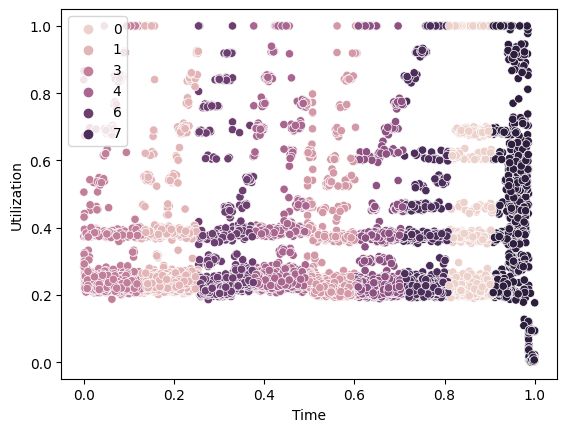

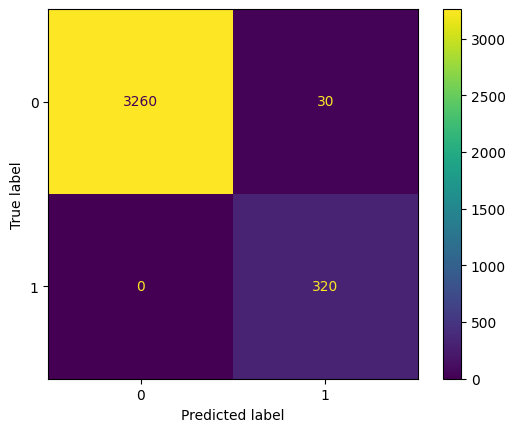

In [ ]:

#visualization & CM for k = 9, which is what was originally used for the presentation


#fit the model and display it by clusters
kmeans = KMeans(n_clusters = 9, random_state = 0, n_init='auto')
kmeans.fit(x2_train)
#graphic in slides
sns.scatterplot(data = timeUtil, x = 'Time', y = 'Utilization', hue = kmeans.labels_)



lis = list(zip(x2_train.flatten(),label_train.flatten()))
anoma = [0]*kmeans.cluster_centers_.size
fine = [0]*kmeans.cluster_centers_.size
#count how many regular points and anomalies are in each cluster
for i in range(len(lis)):
  if lis[i][1] > 0:
    anoma[kmeans.labels_[i]] += 1
  else:
    fine[kmeans.labels_[i]] += 1
#0th address in fine[] is how many regular points are in the 0th cluster
#0th address in anomaly[] is how many anomalies are in the 0th cluster
print("fine:",fine)
print("anomaly:",anoma)
anomPerc = [0]*kmeans.cluster_centers_.size

# % of points in that cluster that are anomalies
for x in range(len(anomPerc)):
  anomPerc[x] = (anoma[x] / (anoma[x] + fine[x]))
print("Anomaly % for each cluster:",anomPerc)


#now we can predict?
predicted = kmeans.predict(x2_test)

#homemade confusion matrix just to double check
CM = [0]*4
# TT, FF, TF, FT
#[320, 3260, 30, 0]
CMreal = [0] * len(y2_test)
for b in range(len(predicted)):
  pred = False
  if anomPerc[predicted[b]] > .2:
    pred = True
    CMreal[b] = 1
  if pred == True and label_test[b] == 1:
    CM[0] += 1
  if pred == False and label_test[b] == 0:
    CM[1] += 1
  if pred == True and label_test[b] == 0:
    CM[2] += 1
  if pred == False and label_test[b] == 1:
    CM[3] += 1
print(CM)


#cm in slides
c_matrix = confusion_matrix(y_true=label_test, y_pred=CMreal, labels=[0, 1])
display = ConfusionMatrixDisplay(c_matrix)
display.plot()







# run through every point, if the point is an anomaly give its cluster +1, find the cluster with the most

